In [11]:
import glob

from amuse.io import read_set_from_file
from amuse.units import units
from amuse.ext.orbital_elements import orbital_elements

import numpy as np
import matplotlib.pyplot as plt

import function_file as ff

In [12]:
states = ff.state_dict()
print(states)

semi_majors = [1.0,2.0, 5.0, 10.0, 20.0, 50.0, 100.0] | units.AU
# semi_majors = [1.0] | units.AU
moon_semi_majors = ff.hill_radius(semi_majors, 1 | units.Msun, 1 | units.Mjupiter)/3
print(moon_semi_majors.in_(units.AU))

{0: ('Other', 'Other'), 1: ('FFPM', 'Free Floating Planet Moon Pair'), 2: ('FFPWM', 'Free Floating Planet Without Moon'), 3: ('FFMBP', 'Free Floating Moon, Bound Planet')}
[0.0227499199763, 0.0454998399525, 0.113749599881, 0.227499199763, 0.454998399525, 1.13749599881, 2.27499199763] au


185
166
94
77
47
32
21


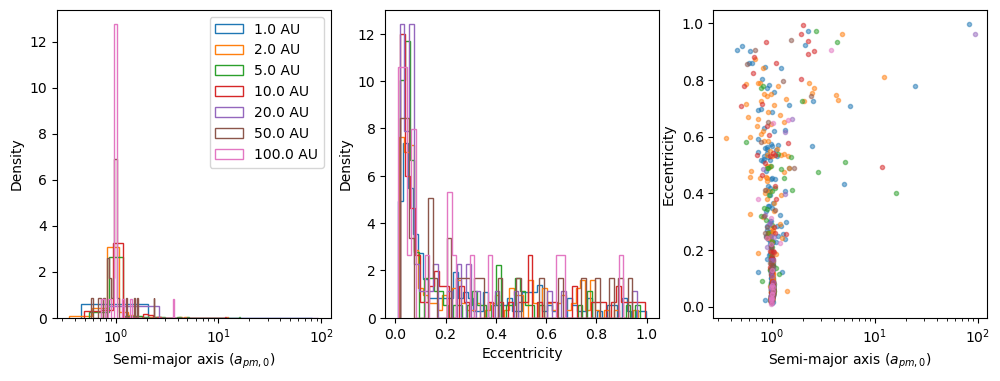

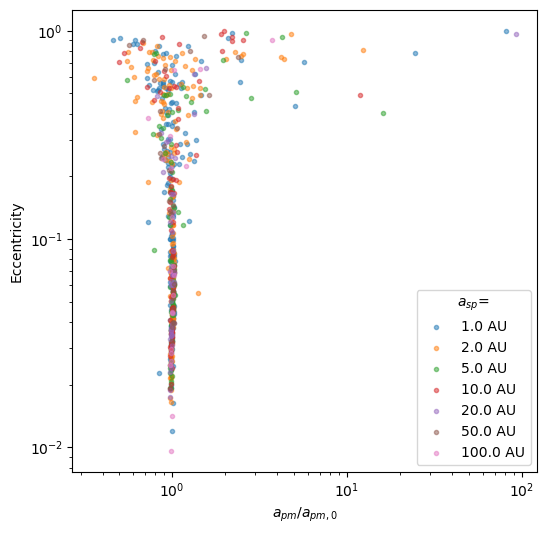

In [13]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(12, 4))

fig2, ax = plt.subplots(1, 1, figsize=(6, 6))

for i in range(len(semi_majors)):
    folder = f'/home/ybadoux/Documents/MRP/ALICE_spm/old/output_sm_axis{semi_majors[i].value_in(units.AU)}'
    files = glob.glob(folder + '/*_1.amuse')
    print(len(files))

    npy_file = f'/home/ybadoux/Documents/MRP/ALICE_spm/old/results_semi-major_{semi_majors[i].value_in(units.AU)} au.npy'
    data_npy = np.load(npy_file)

    a_pm_list = np.zeros(len(files))
    e_pm_list = np.zeros(len(files))
    impact_parameters = np.zeros(len(files))
    sim_idx_list = np.zeros(len(files))

    for j,file in enumerate(files):
        sim_idx = int(file.split('/')[-1].split('_')[0])
        sim_idx_list[j] = sim_idx
        data = read_set_from_file(file, 'amuse')

        planet = data[data.name == 'planet'][0]
        moon = data[data.name == 'moon0'][0]

        # 2 semi-major axis, 3 eccentricity
        orb_el = orbital_elements(planet, moon)
        a_pm_list[j] = orb_el[2][0]/moon_semi_majors[i]
        e_pm_list[j] = orb_el[3][0]

        impact_parameters[j] = data_npy['b'][data_npy['index'] == sim_idx][0]

    # Plotting
    ax0.hist(a_pm_list, histtype='step', density=True, bins=50, label=f'{semi_majors[i].value_in(units.AU)} AU')
    ax1.hist(e_pm_list, histtype='step', density=True, bins=50, label=f'{semi_majors[i].value_in(units.AU)} AU')
    ax2.scatter(a_pm_list, e_pm_list, label=f'{semi_majors[i].value_in(units.AU)} AU', marker='.', alpha=0.5)

    ax.scatter(a_pm_list, e_pm_list, label=f'{semi_majors[i].value_in(units.AU)} AU', marker='.', alpha=0.5)

ax.set_xlabel(r'$a_{pm} / a_{pm,0}$')
ax.set_ylabel(r'Eccentricity')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(0.3,10)
ax.legend(title=r'$a_{sp}$=')
fig2.savefig('semi-major_axis_vs_eccentricity.png', dpi=300, bbox_inches='tight')

ax0.set_xlabel(r'Semi-major axis ($a_{pm,0}$)')
ax0.set_ylabel('Density')
ax0.legend()
ax0.set_xscale('log')

ax1.set_xlabel(r'Eccentricity')
ax1.set_ylabel('Density')

ax2.set_xlabel(r'Semi-major axis ($a_{pm,0}$)')
ax2.set_ylabel(r'Eccentricity')
ax2.set_xscale('log')

In [14]:
print(sim_idx_list[a_pm_list > 3], a_pm_list[a_pm_list > 3])
print(234, 30)
print(data_npy.dtype.names)
print(data_npy[data_npy['index'] == 30][0])

init_cond = data_npy[data_npy['index'] == 30][0]
print(init_cond['b'])

[ 30.] [ 3.71368846]
234 30
('a_sp', 'v20', 'b', 'phi', 'theta', 'psi', 'f_pl', 'f_moon', 'end_time', 'state', 'index')
( 100.,  3.14455084,  199.74132519,  5.29187374,  0.35437442,  0.41717944,  1.42129087,  2.7090541,  17892.30000002, 1, 30)
199.741325186


In [20]:
from run_simulation import run_simulation
from initial_conditions import generate_initial_conditions, add_encounter

bodies = generate_initial_conditions(1|units.Msun,
                                     1|units.Mjupiter,
                                     100|units.AU,
                                     1.4815e23 | units.kg,
                                     f_pl=init_cond['f_pl'],
                                     f_moon=init_cond['f_moon'],
                                     radii=[1|units.Rsun, 1|units.Rjupiter, 2631|units.km])

bodies = add_encounter(bodies,
                       1|units.Msun,
                       init_cond['b']|units.AU,
                       init_cond['v20']|units.kms,
                       init_cond['phi'],
                       init_cond['theta'],
                       init_cond['psi'],
                       radius=1|units.Rsun)

In [21]:
evolved, _, end_time, stop_code = run_simulation(bodies, stop_on_collision=True)

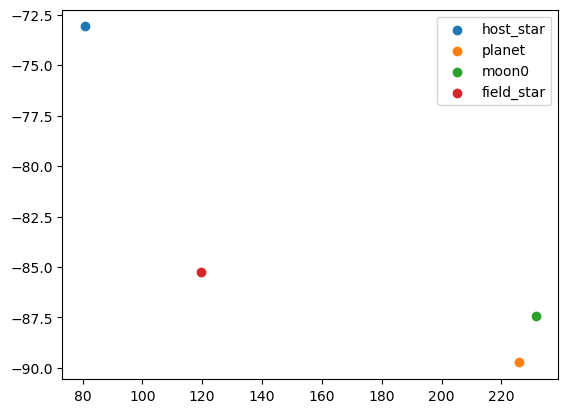

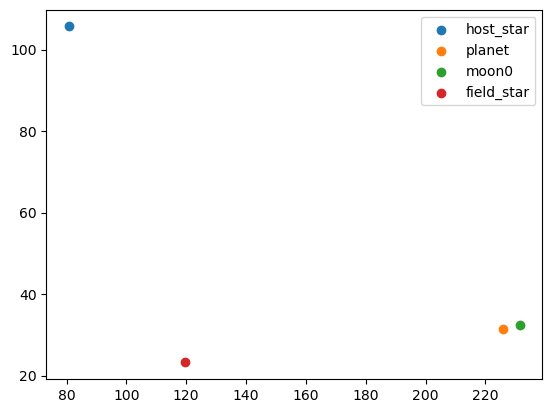

In [28]:
for body in evolved:
    plt.scatter(body.x.value_in(units.AU), body.y.value_in(units.AU), label=body.name)

plt.legend()
plt.show()

for body in evolved:
    plt.scatter(body.x.value_in(units.AU), body.z.value_in(units.AU), label=body.name)
plt.legend()
plt.show()